# Let's build a digit classifier!

## Load MNIST training and test set

In [21]:
from torchvision import datasets
from torchvision.transforms import ToTensor

training_data = datasets.MNIST(
    'data/',
    train = True,
    transform = ToTensor(),
    download = True)

test_data = datasets.MNIST(
    'data/',
    train = False,
    transform = ToTensor(),
    download = True)
    
print(len(all_training_data), len(test_data))

60000 10000


## Multi-layerPerceptron (Feed-Forward)

In [194]:
from torch import nn

class DigitClassifierMLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.num_hidden = 8
        # layers with weights
        self.layers = nn.Sequential(  
          nn.Linear(28 * 28, self.num_hidden),
            nn.ReLU(),
            nn.Linear(self.num_hidden, 10),
            nn.LogSoftmax(dim=1))

    # input: [N, 1, 28, 28]
    def forward(self, input):
        # [N, 28 * 28]
        x = input.reshape(-1, 28 * 28)
        log_prob = self.layers(x)
        return log_prob

## Instantiate the model

In [106]:
digit_classifier_mlp = DigitClassifierMLP()

## Try it out

In [217]:
import torch
import random
from matplotlib import pyplot

def visualize(model, data):
    (image, correct_label) = random.choice(test_data)
    # image: 1 x 28 x 28
    print(f'Correct answer: {correct_label}')
    log_prob = model(image.reshape(1, 1, 28, 28))
    # log_prob: 1 x 10
    prob = log_prob[0].exp().tolist()
    fig, axes = pyplot.subplots(1, 2, figsize=(12, 5))
    axes[0].imshow(image[0])
    axes[1].bar(list(range(10)), prob)
    pyplot.show()

Correct answer: 0


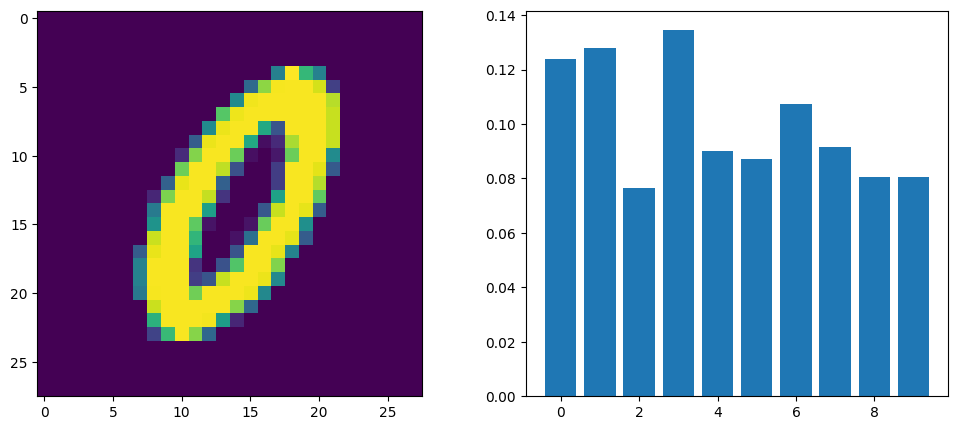

In [74]:
visualize(digit_classifier_mlp, test_data)

## Evaluate the model on test data

In [88]:
from torch.utils.data import DataLoader

def evaluate(model, data):
    cost_fn = nn.NLLLoss()
    data_loader = DataLoader(data, batch_size = 32)
    cost = 0.0
    correct = 0
    with torch.no_grad():
        for (images, correct_labels) in data_loader:
            log_prob = model(images)
            cost += len(images) * cost_fn(log_prob, correct_labels).item()
            correct += (log_prob.argmax(1) == correct_labels).sum().item()
    cost /= len(data)
    correct /= len(data)
    print(f'Evaluation cost: {cost:.8f} correct: {100 * correct:.2f}%')
    return cost

In [89]:
evaluate(digit_classifier_mlp, test_data)

Evaluation cost: 2.32213990 correct: 9.11%


2.3221399044036866

### Base cost for random guessing

In [81]:
import math
math.log(10)

2.302585092994046

## Train MLP

In [114]:
from torch import optim

def training_epoch(model, data):
    cost_fn = nn.NLLLoss()
    data_loader = DataLoader(data, batch_size=32, shuffle=True)
    optimizer = optim.AdamW(model.parameters(), lr = 0.001)
    total_cost = 0.0
    for (images, labels) in data_loader:
        log_prob = model(images)
        cost = cost_fn(log_prob, labels)
        total_cost += len(images) * cost.item()
        # backpropagation
        optimizer.zero_grad()
        cost.backward()
        optimizer.step()
    total_cost /= len(data)
    print(f'Training cost: {total_cost:.8f}')
    return total_cost

In [115]:
def train(model):
    training_costs = []
    validation_costs = []
    for epoch in range(10):
        training_cost = training_epoch(model, training_data)
        validation_cost = evaluate(model, validation_data)
        training_costs.append(training_cost)
        validation_costs.append(validation_cost)
    return training_costs, validation_costs

In [249]:
digit_classifier_mlp = DigitClassifierMLP()
training_costs, validation_costs = train(digit_classifier_mlp)

Training cost: 0.65642801
Evaluation cost: 0.37888042 correct: 89.39%
Training cost: 0.32942949
Evaluation cost: 0.32962841 correct: 90.87%
Training cost: 0.29276134
Evaluation cost: 0.30634375 correct: 91.56%
Training cost: 0.27693607
Evaluation cost: 0.30411864 correct: 91.67%
Training cost: 0.26622583
Evaluation cost: 0.29416753 correct: 91.77%
Training cost: 0.25867594
Evaluation cost: 0.29272067 correct: 92.01%
Training cost: 0.25351843
Evaluation cost: 0.29173447 correct: 91.83%
Training cost: 0.25002986
Evaluation cost: 0.29559755 correct: 91.73%
Training cost: 0.24582088
Evaluation cost: 0.29193304 correct: 91.83%
Training cost: 0.24277446
Evaluation cost: 0.28382765 correct: 91.86%


## Visualize training progress

In [165]:
def visualize_cost(training_costs, validation_costs):
    pyplot.plot(range(len(training_costs)), training_costs, label = 'training')
    pyplot.plot(range(len(validation_costs)), validation_costs, label = 'validation')
    pyplot.legend()
    pyplot.show()

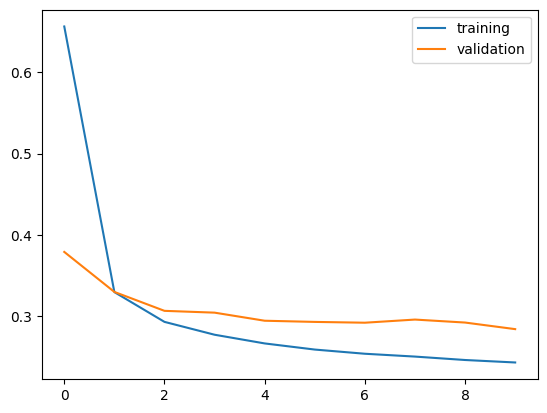

In [253]:
visualize_cost(training_costs, validation_costs)

## Try it out again

Correct answer: 5


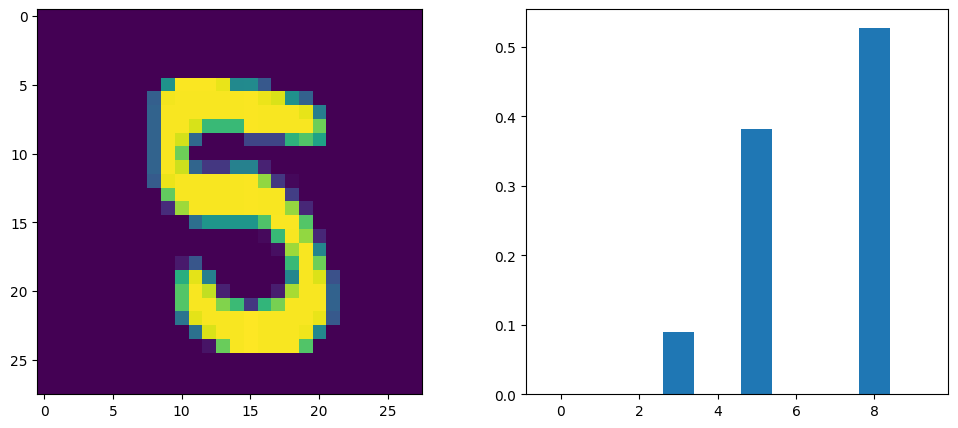

In [172]:
visualize(digit_classifier_mlp, test_data)

# Convolutional Neural Network

In [195]:
class DigitClassifierCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.channels_1 = 16
        self.channels_2 = 8
        self.num_hidden = 16
        self.layers = nn.Sequential(
            # 5^2 * 1 * 16 = 400 params
            nn.Conv2d(1, self.channels_1, 5, padding='same'),
            # N x 14 x 14 x 8
            nn.MaxPool2d(2),
            nn.ReLU(),
            # 5^2 * 16 * 8 = 3200 params
            nn.Conv2d(self.channels_1, self.channels_2, 5, padding='same'),
            # N x 7 x 7 x 8
            nn.MaxPool2d(2),
            nn.ReLU(),
            # N x 392
            nn.Flatten(1),
            # 392 * 16 = 6272 params
            nn.Linear(7 * 7 * self.channels_2, self.num_hidden),
            nn.ReLU(),
            nn.Linear(self.num_hidden, 10),
            nn.LogSoftmax(dim=1))

    # input: [N, 1, 28, 28]
    def forward(self, input):
        log_prob = self.layers(input)
        return log_prob

## Try out untrained CNN

In [196]:
digit_classifier_cnn = DigitClassifierCNN()

Correct answer: 7


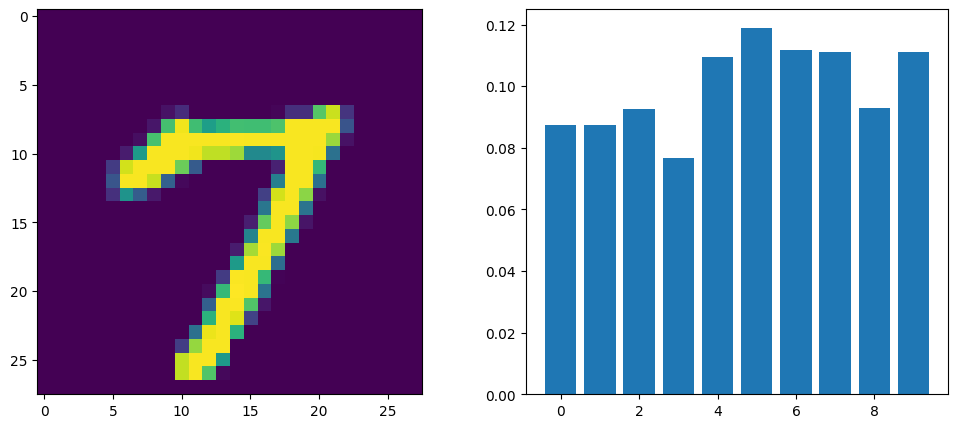

In [215]:
visualize(digit_classifier_cnn, test_data)

In [216]:
evaluate(digit_classifier_cnn, test_data)

Evaluation cost: 2.31667092 correct: 8.92%


2.316670923614502

## Train CNN

In [218]:
digit_classifier_cnn = DigitClassifierCNN()
training_costs, validation_costs = train(digit_classifier_cnn)

Training cost: 0.31763604
Evaluation cost: 0.12594725 correct: 96.37%
Training cost: 0.09964119
Evaluation cost: 0.10757434 correct: 96.91%
Training cost: 0.07420451
Evaluation cost: 0.10344275 correct: 97.05%
Training cost: 0.06014888
Evaluation cost: 0.07162948 correct: 97.87%
Training cost: 0.05125185
Evaluation cost: 0.07210433 correct: 97.88%
Training cost: 0.04486711
Evaluation cost: 0.06344544 correct: 98.14%
Training cost: 0.03916650
Evaluation cost: 0.06607200 correct: 98.30%
Training cost: 0.03748237
Evaluation cost: 0.05927386 correct: 98.36%
Training cost: 0.03271680
Evaluation cost: 0.06440850 correct: 98.34%
Training cost: 0.03011806
Evaluation cost: 0.06591715 correct: 98.22%


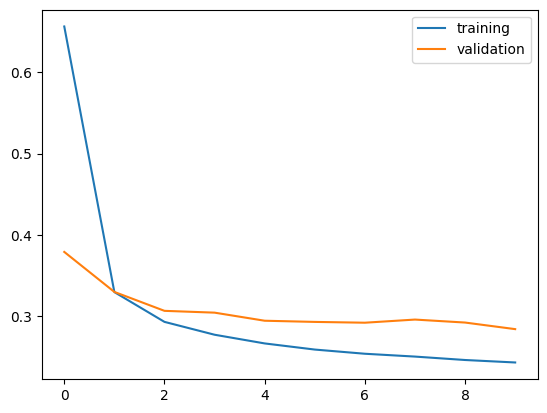

In [254]:
visualize_cost(training_costs, validation_costs)

## Try out trained CNN

Correct answer: 4


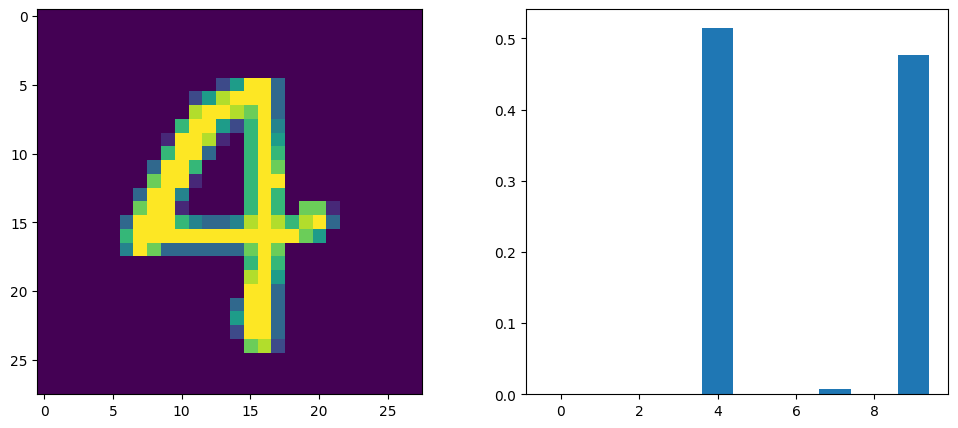

In [248]:
visualize(digit_classifier_mlp, test_data)